# Machine Learning Parte I - Aprendizaje Supervisado

*Modificado de guía de trabajo de Marina Villacampa*



## Paquetes Relevantes

### Scikit-learn

[Guía de Uso](https://scikit-learn.org/stable/user_guide.html)

Scikit-learn es una librería de machine learning de código abierto.
Se puede utilizar para aprendizaje **supervisado** y **no supervisado**.

También incluye herramientas para el ajuste del modelo, pre-procesamiento de datos, selección y evaluación del modelo, entre otros.

**Dependencias:** Scikit-learn depende de NumPy y SciPy.

In [ ]:
# @title Instalación de paquetes necesarios para machine learning

!pip install numpy scipy scikit-learn pandas

In [ ]:
# @title Instalación de paquetes necesarios para quimioinformática
!pip install rdkit

## Linear Models

### Modelos con una única característica

En términos matemáticos un modelo lineal puede definirse como:

$$
y = mx + b
$$

Donde:

* $y$ es el valor a predecir
* $m$ es la pendiente de la recta
* $x$ es nuestro dato de entrada
* $b$ es la ordenada al origen

En machine learning, esa ecuación se ve como:

$$
y' = b + w_1 x_1
$$

Donde:

* $y'$ es la *etiqueta* predicha (la salida)
* $b$ es el **bias** del modelo. Es un **parámetro** del modelo y se calcula durante el entrenamiento. A veces también se representa como $w_0$
* $w_1$ es el **peso** que se le da a la característica. Es un **parámetro** del modelo y se calcula durante el entrenamiento.
* $x_1$ es la característica (la entrada)

Durante el entrenamiento, el modelo calcula el peso y el bias y produce el mejor modelo que luego será utilizado para realizar predicciones.



### Modelos con múltiples características

Un modelo lineal más sofisticado puede basarse en muchas características, cada una de las cuales tendrá su propio peso.

$$
y' = b + w_1 x_1 + w_2 x_2 + w_3 x_3 + w_4 x_4 + w_5 x_5
$$

La variable predicha $y'$ según este modelo dependerá de 5 características ($x_1, x_2, x_3, x_4, x_5$). Por lo tanto, se ajustarán en el modelo un bias ($b$) y 5 pesos ($w_1, w_2, w_3, w_4, w_5$)

### Actividad Nro 1

La **solubilidad en agua** es una propiedad física de interés de una molécula para la química medicinal o la agroquímica ya que afecta la toma y distribución de los compuestos activos en individuos o el ambiente, afectando directamente su eficacia potencial.

Determinar la solubilidad en agua es un experimento que lleva tiempo, y por lo tanto sería útil poder evaluar la solubilidad de modo computacional.

**Objetivo:** Construir un modelo que permita predecir la solubilidad en agua de moléculas orgánicas.

Para esto se utilizará los datos de ESOL [Delaney et al 2004](https://pubs.acs.org/doi/10.1021/ci034243x)

Para esto, en lugar de obtener los datos desde una base de datos, los descargamos desde un repositorio de github, y creamos un directorio en la nube donde los guardamos (noten que no es su drive).

In [ ]:
# @title Descarga de los datos de ESOL

# Creo un directorio en la nube (esto no está en el drive)
!mkdir data

# Traigo los datos (esol.csv) y los guardo en el directorio data (-O data/esol.csv)
!wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/02%20-%20Supervised%20Learning/data/esol.csv -O data/esol.csv

mkdir: cannot create directory ‘data’: File exists
--2025-06-09 18:49:26--  https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/02%20-%20Supervised%20Learning/data/esol.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34453 (34K) [text/plain]
Saving to: ‘data/esol.csv’

data/esol.csv       100%[===================>]  33.65K  --.-KB/s    in 0.007s  

2025-06-09 18:49:26 (4.72 MB/s) - ‘data/esol.csv’ saved [34453/34453]



In [ ]:
# @title Importando las librerías para trabajar con datos quimioinformáticos
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

In [ ]:
# @title Importando las librerías para trabajar con ML
import numpy as np
import scipy as sp
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# @title Importando las librerías necesarias para graficar
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# @title Leyendo los datos: `data/esol.csv` y creando un dataframe

datos = pd.read_csv("data/esol.csv")
datos.head()

# Número de datos
print(datos.shape[0])

# Identificación de Columnas
print(datos.columns)

# Limpiamos datos duplicados y con NAs
datos.drop_duplicates(inplace=True)
print(datos.shape[0])
datos.dropna(inplace=True)
print(datos.shape[0])

1128
Index(['smiles', 'log solubility (mol/L)'], dtype='object')
1128
1128


### Características a evaluar (featurización de las moléculas)

Los SMILES son strings y en sí mismos no nos permiten construir un modelo de ML.

Por lo tanto, es necesario obtener las características de las moléculas.

En particular, los autores utilizan 8 parámetros:

1. **logP**
2. **Peso Molecular (MWT).**
3. **Rotatable bonds (RB).**
4. **Proporción de Aromáticos (AP).** Es la proporción de átomos pesados de la molécula que están en un anillo aromático.
5. **Proporción de no carbonos.** Es la proporción de átomos pesados en la molécula que no son un carbono.
6. **H-bond donor counts.**
7. **H-bond acceptor counts.**
8. **Polar surface areas.**

Vamos a agregar esos datos a nuestro set de datos.

In [ ]:
# @title Agregamos los descriptores
# estas son las librerías y módulos que estamos usando
#from rdkit import Chem
#from rdkit.Chem import Descriptors

res_all_dict = {}

for index,row in datos.iterrows():
  smiles = row['smiles']
  molecula = Chem.MolFromSmiles(smiles)
  solubilidad = row['log solubility (mol/L)']

  res_dict = {}
  res_dict.update({"log solubility (mol/L)": solubilidad})
  res_dict.update({"logP_value":Descriptors.MolLogP(molecula)})
  res_dict.update({"exact_mol_wt":Descriptors.ExactMolWt(molecula)})
  res_dict.update({"num_rotatable_bonds":Descriptors.NumRotatableBonds(molecula)})
  res_dict.update({"num_h_donors":Descriptors.NumHDonors(molecula)})
  res_dict.update({"num_h_acceptors":Descriptors.NumHAcceptors(molecula)})
  res_dict.update({"tpsa":Chem.rdMolDescriptors.CalcTPSA(molecula)})
  res_dict.update({"atomos_aromaticos_proportion":len(molecula.GetAromaticAtoms()) / molecula.GetNumAtoms()})
  res_dict.update({"non_Carbono_proportion":(molecula.GetNumAtoms() - len(molecula.GetSubstructMatches(Chem.MolFromSmiles("C"), maxMatches=molecula.GetNumAtoms()))) / molecula.GetNumAtoms()})

  res_all_dict[smiles] = res_dict

# Los valores del diccionario los transformo a un data frame usando las keys (smiles en este caso) como rows
df_con_descriptores = pd.DataFrame.from_dict(res_all_dict,orient='index')
df_con_descriptores.head()

# Elimino los smiles como indice y los guardo en una columna
df_con_descriptores.reset_index(inplace=True)
# Reemplazo el nombre de la columna que se crea como "index" a smiles
df_con_descriptores.rename(columns={'index': 'smiles'}, inplace=True)

# Veo que todos los descriptores hayan funcionado
df_con_descriptores.dropna(inplace=True)
print(df_con_descriptores.shape[0])

df_con_descriptores.head()

1128


,smiles,log solubility (mol/L),logP_value,exact_mol_wt,num_rotatable_bonds,num_h_donors,num_h_acceptors,tpsa,atomos_aromaticos_proportion,non_Carbono_proportion
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,-3.10802,457.158411,7,7,12,202.32,0.187500,0.375000
1,Cc1occc1C(=O)Nc2ccccc2,-3.30,2.84032,201.078979,2,1,2,42.24,0.733333,0.200000
2,CC(C)=CCCC(C)=CC(=O),-2.06,2.87800,152.120115,4,0,1,17.07,0.000000,0.090909
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,6.29940,278.109550,0,0,0,0.00,1.000000,0.000000
4,c1ccsc1,-1.33,1.74810,84.003371,0,0,1,0.00,1.000000,0.200000


### Mirando un poco los datos

Es necesario interesante ver que descriptores explicarían mejor la sobulidad y conocer, por ejemplo, el rango de valores de nuestros datos y su distribución para poder empezar a conocerlos.

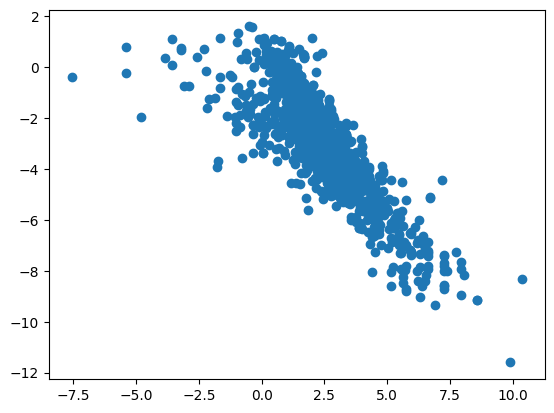

In [ ]:
# @title Gráfico de puntos de ejemplo
plt.scatter(df_con_descriptores['logP_value'],df_con_descriptores['log solubility (mol/L)'])
plt.show()

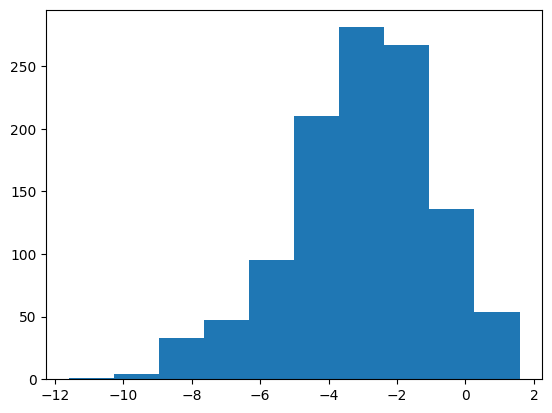

In [ ]:
# @title Histograma de Ejemplo
plt.hist(df_con_descriptores['log solubility (mol/L)'], bins=None, range=None, density=False, histtype='bar', color=None, label=None)
plt.show()

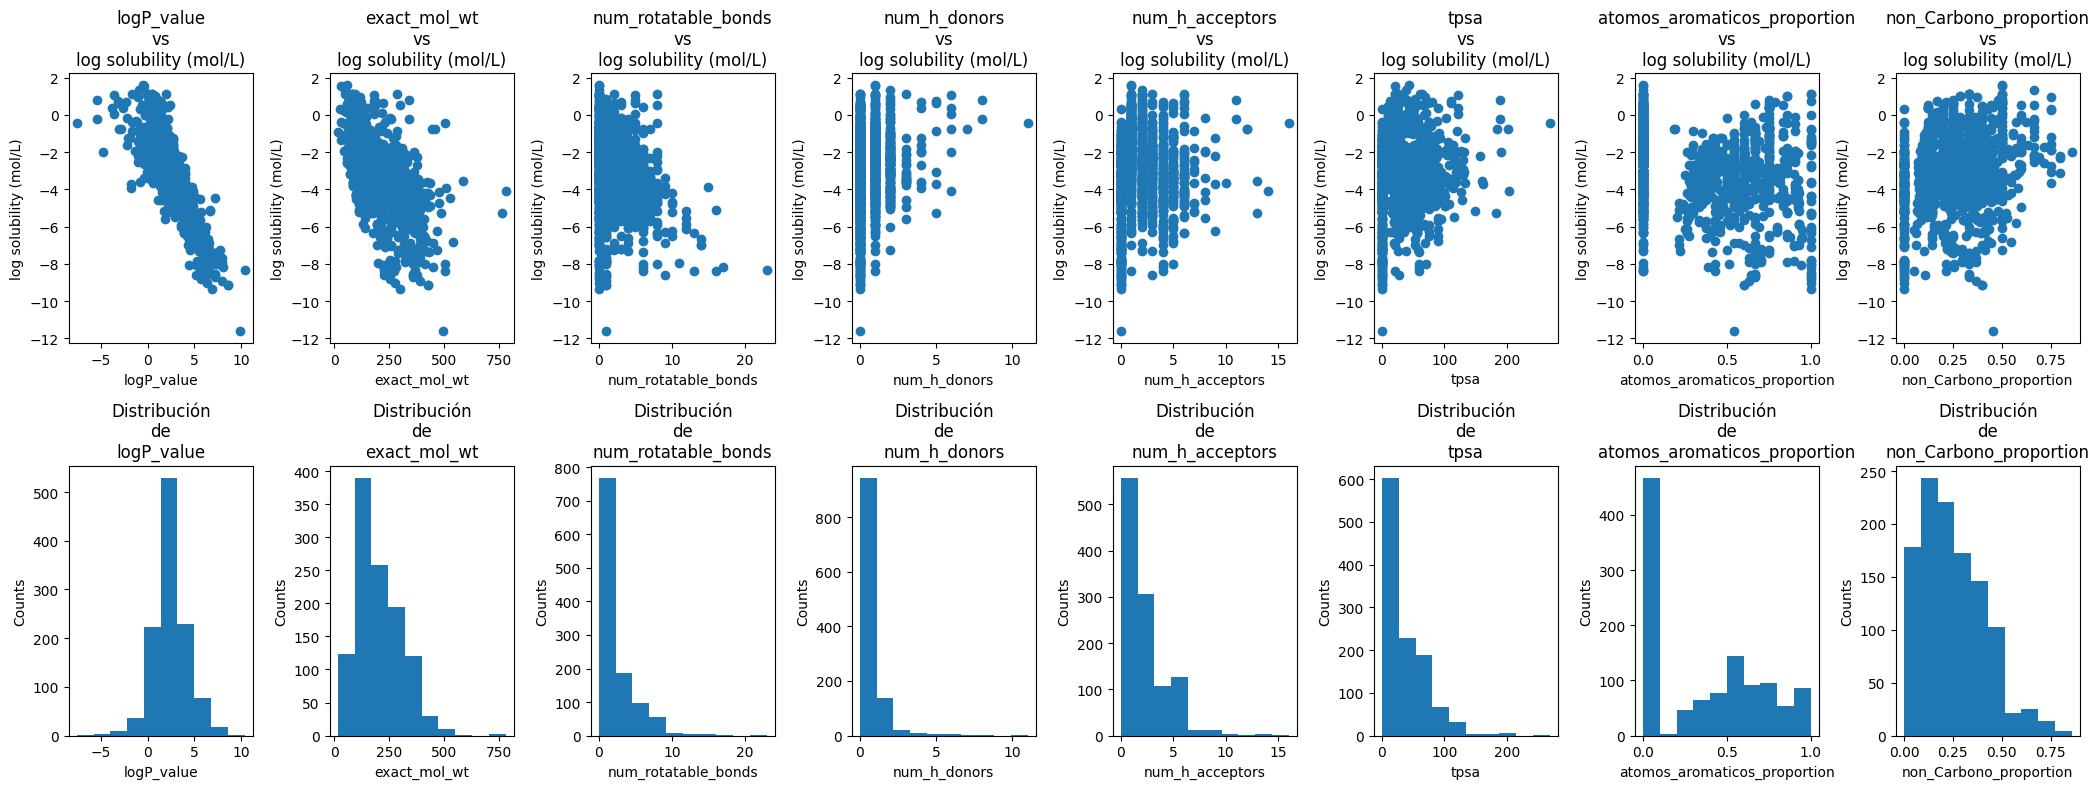

In [ ]:
# @title Complete el código para realizar el histograma de los descriptores

# Creamos una figura con 16 subplots (uno para cada descriptor y dos filas, una con los scatter plots y otra con los histogramas)
fig, axes = plt.subplots(2, 8)
fig.set_size_inches(21, 8)

# Iteramos a través de las columnas del dataframe empezando por la tercera columna
# (la primera columna (0) es smiles, la segunda columna (1) es solubilidad)

for i in range(2, df_con_descriptores.shape[1]): # Empiezo por la tercera columna
    ax1 = axes[0,i-2] # Selecciono el subplot apropiado
    ax1.scatter(df_con_descriptores.iloc[:,i],df_con_descriptores['log solubility (mol/L)'])
    ax1.set_title(f'{df_con_descriptores.columns[i]}\nvs\n{df_con_descriptores.columns[1]}')
    ax1.set_xlabel(df_con_descriptores.columns[i])
    ax1.set_ylabel(df_con_descriptores.columns[1])

    ax2 = axes[1,i-2]
    ax2.hist(df_con_descriptores.iloc[:,i], bins=None, range=None, density=False, histtype='bar', color=None, label=None)

    # Le pongo titulo a ejes y plot
    ax2.set_xlabel(df_con_descriptores.columns[i])
    ax2.set_ylabel('Counts')
    ax2.set_title(f'Distribución\nde\n{df_con_descriptores.columns[i]}')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()


**¿Hay alguna característica que explique mejor la solubilidad?**


**¿Es necesario estandarizar los datos?**

### Estandarizar los datos ¿Antes o después de dividirlos?

En general, se realiza la división de datos en **set de entrenamiento**, **set de validación** y **set de evaluación**.

De esta manera, se evita cualquier *influencia* de los sets de validación y evaluación en el set de entrenamiento.

Pero OJO, la estandarización de los datos se hace con la estandarización utilizada en el set de entrenamiento.

### Creación de Modelos

Vamos a crear 2 modelos, uno usando solo el logP y otro usando todas las características

## Modelo con LogP

### División de datos

Vamos a crear 3 sets de datos

1. Set de entrenamiento (training set)
2. Set de validación (validation set)
3. Set de evaluación (test set)

In [ ]:
# @title Diviendo datos
# Librería que deberíamos importar
# from sklearn.model_selection import train_test_split

X = df_con_descriptores.iloc[:,2:] # guardo los descriptores
y = df_con_descriptores.iloc[:,1] # guardo la solubilidad

X_train, X_tests, y_train, y_tests = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tests, y_tests, test_size=0.5, random_state=42)

print(f"Tamaño del set de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del set de validación: {X_val.shape[0]}")
print(f"Tamaño del set de evaluación: {X_test.shape[0]}")

print(type(X))
print(type(X_train))


Tamaño del set de entrenamiento: 902
Tamaño del set de validación: 113
Tamaño del set de evaluación: 113
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Estandarizacion de datos

`sklearn` tiene varios módulos para la estandarización de datos, puede leer más sobre ellos [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

Brevemente:

`StandardScaler` es el z-score

`MinMaxScaler` es la escalado lineal

In [ ]:
# @title Estandarización de los datos de entrenamiento

# Importando StandardScaler.
# from sklearn.preprocessing import StandardScaler
# Instancio StandardScaler.
# scaler = StandardScaler()


# Importando MinMaxScaler.
from sklearn.preprocessing import MinMaxScaler

# Instancio MinMaxScaler
mi_scaler_uno = MinMaxScaler()
# Defino los parámetros para escalar

# OJO el escalador no acepta pandas.series!
mi_scaler_uno.fit(X_train['logP_value'].values.reshape(-1,1))

# Escalo los datos
X_train_scaled_1 = mi_scaler_uno.transform(X_train['logP_value'].values.reshape(-1,1))

#
print(type(X_train_scaled_1))
print(X_train_scaled_1[0])

<class 'numpy.ndarray'>
[0.48454936]


In [ ]:
# @title Estandarización del set de datos de validación y evaluación
X_val_scaled_1 = mi_scaler_uno.transform(X_val['logP_value'].values.reshape(-1,1))
X_test_scaled_1 = mi_scaler_uno.transform(X_test['logP_value'].values.reshape(-1,1))

### Creo el modelo con una característica



In [ ]:
# @title Creación del modelo
# Librerías que deberíamos importar
# from sklearn.linear_model import LinearRegression

# Instantiate linear regression model.
modelo_1 = LinearRegression()
# ajusto el modelo
modelo_1.fit(X_train_scaled_1, y_train)

LinearRegression()

In [ ]:
# @title Realizamos predicciones en el set de validación
y_pred_1 = modelo_1.predict(X_val_scaled_1)

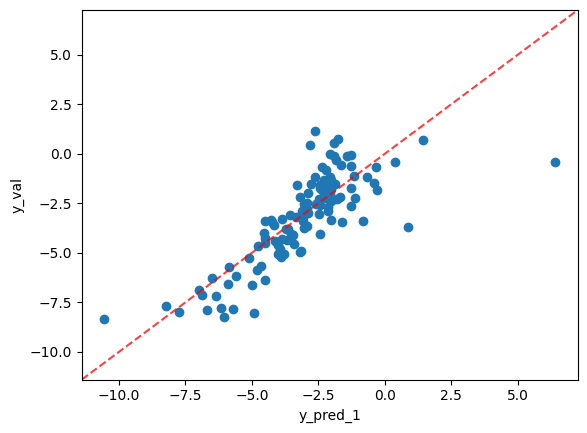

In [ ]:
plt.scatter(y_pred_1,y_val)
# @title Comparamos los datos haciendo un plot de y_pred vs y_val con diagonal de pendiente 1
limits = [
    np.min([plt.xlim(), plt.ylim()]),  # min de ambos ejes
    np.max([plt.xlim(), plt.ylim()]),  # max de ambos ejes
]
plt.plot(limits, limits, "red", linestyle="--", alpha=0.75, label="Identity")
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel("y_pred_1")
plt.ylabel("y_val")
plt.show()


### Evaluación del modelo

Una vez que tenemos los datos predichos (y_pred) a partir del set de validación, es necesario evaluar la *performancia* del algoritmo.

Existen muchas métricas las más comunes son:

* $R^2$
* $MSE$
* $RMSE$
* $MAE$

Para ver [aquí](https://scikit-learn.org/stable/api/sklearn.metrics.html) todas las métricas diponibles en `sklearn`.


#### **R-squared y R-squared adjusted**

R-squared mide la proporción de la varianza en la variable dependiente explicada por la o las variables independientes del modelo.

$$
R^2 = 1 - \sum_{i}^{n} \frac{(y_{observada} - y_{pred})^2}{(y_{observada} - \overline{y})^2}
$$

donde:

* $y_{observada}$: Son los valores observados. En nuestro caso $y_{val}$

* $y_{pred}$: Son los valores predichos.

* $\overline{y}$: Es la media de los valores observados. En nuestro caso la media de $y_{val}$


 Al igual que R-squared, también explica la varianza, pero ajusta el valor del R-squared penalizando la inclusión de variables irrelevantes. Para esto, considera el número de predictores y el tamaño de la muestra:

$$
R^2_{adj} = 1 - \frac{(R^2 - 1)(N - 1)}{N - p - 1}
$$

donde:

* $R^2$: Es el r-squared

* $N$: Es el número de datos

* $p$: Es el número de predictores o características.

**Nota:** Cuando p es 1, $R^2_{adj} \sim R^2$


$R^2 = 1$: El modelo explica de manera perfecta toda la varianza en la variable

$R^2 = 0$: El modelo no explica nada de la varianza, las predicciones no son mejores que simplemente usar la media.

$R^2 < 0$: El medelo es peor que simplemente usar la media, indicando un pobre ajuste.

**Importante**

Un $R^2$ **mayor** no es siempre mejor. Puede estar indicando **overfitting**

Agregar más características puede aumentar de manera artificial el $R^2$.

Cuando se usan regresiones múltiples, conviene usar el $R^2_{adj}$ para evitar variables innecesarias.


### **Mean Squared Error (MSE)** y **Mean Absolute Error (MAE)**

Es el promedio de las diferencias entre el valor observado y el predicho (o sea, el error) al cuadrado.  Un bajo MSE indica a mejor ajuste del modelo.

Como los errores son elevados al cuadrado antes de hacer el promedio, errores grandes son más penalizados que errores pequeños (menores a uno).

Por lo tanto, MSE es muy sensible a outliers.

$$
MSE = \frac{1}{n} \sum_{i}^{n} (y_{observada,i}-y_{pred,i})^2
$$

$$
MAE = \frac{1}{n} \sum_{i}^{n} |y_{observada,i}-y_{pred,i}|
$$




In [ ]:
# @title Evaluando el modelo
# Libreríamos que deberíamos importar
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate and print errors.
r2 = r2_score(y_val, y_pred_1)
print(f"R-squared: {r2:.4f}")

predictores = 1
n_sample = len(y_val)
r2_adj = 1 - ((1 - r2) * (n_sample - 1) / (n_sample - predictores - 1))

print(f"R-squared_adj: {r2_adj:.4f}")

mse = mean_squared_error(y_val, y_pred_1)
print(f"Mean squared error: {mse:.4f}")

rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")

mae = mean_absolute_error(y_val, y_pred_1)
print(f"Mean absolute error: {mae:.4f}")

metricas_modelo1 = {"r2": r2, "r2_adj": r2_adj, "mse": mse, "rmse": rmse, "mae": mae}


R-squared: 0.6208
R-squared_adj: 0.6174
Mean squared error: 1.9542
Root mean squared error: 1.3979
Mean absolute error: 0.9924


In [ ]:
# @title Obteniendo los pesos y el bias
print("Feature: logP")
print("Bias o Intercept:", modelo_1.intercept_)
print("Peso o coeficiente:", modelo_1.coef_[0])

Feature: logP
Bias o Intercept: 4.364994889895979
Peso o coeficiente: -14.440876397493563


### Modelo con Muchas características

Dado que nuestro modelo no parece ser muy bueno, vamos a probar construir un nuevo modelo con las 8 características.

Lo vamos a hacer más rápido que antes.

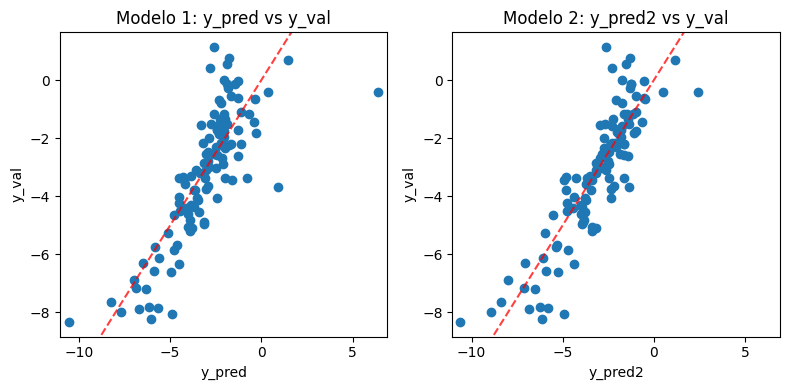

In [ ]:
# @title Creación del modelo
# Librerías que deberíamos importar
# from sklearn.linear_model import LinearRegression

# los datos ya están divididos, solo hay que transformarlos
mi_scaler_ocho = MinMaxScaler()
mi_scaler_ocho.fit(X_train)
X_train_scaled_8 = mi_scaler_ocho.transform(X_train)
X_val_scaled_8 = mi_scaler_ocho.transform(X_val)
X_test_scaled_8 = mi_scaler_ocho.transform(X_test)

# Instantiate linear regression model.
modelo_2 = LinearRegression()
# ajusto el modelo
modelo_2.fit(X_train_scaled_8, y_train)
y_pred2 = modelo_2.predict(X_val_scaled_8)


# Realizamos el plot de ypred e ypred2 vs y-val
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

data_to_plot = {"y_pred": y_pred_1, "y_pred2": y_pred2}
xmin, xmax, ymin, ymax = min(y_pred_1) - 0.5, max(y_pred_1) + 0.5, min(y_val) - 0.5, max(y_val) + 0.5
for index,key in enumerate(data_to_plot.keys()):
    ax = axes[index]
    ax.scatter(data_to_plot[key], y_val)
    limits = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min de ambos ejes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max de ambos ejes
            ]
    ax.plot(limits, limits, "red", linestyle="--", alpha=0.75, label="Identity")
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(key)
    ax.set_ylabel("y_val")
    ax.set_title(f"Modelo {index+1}: {key} vs y_val")

plt.tight_layout()
plt.show()


Intercept: 4.43

Feature Coefficients:
                         Feature  Coefficient
0                    logP_value       -12.37
1                  exact_mol_wt        -4.44
2           num_rotatable_bonds        -0.21
3                  num_h_donors        -0.12
4               num_h_acceptors         2.67
5                          tpsa        -3.14
6  atomos_aromaticos_proportion        -0.27
7        non_Carbono_proportion         0.78


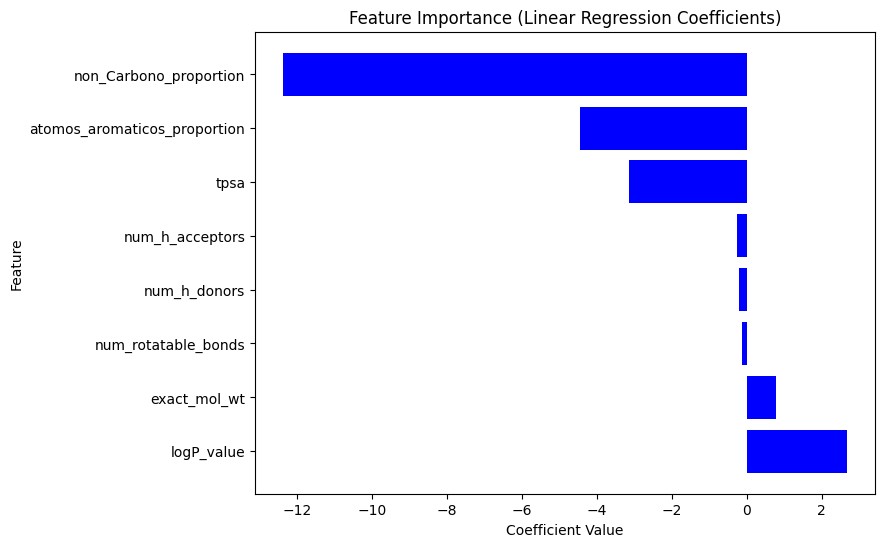

In [ ]:
print(f'Intercept: {modelo_2.intercept_.round(2)}')

coeff_df = pd.DataFrame({"Feature": X.columns, "Coefficient": modelo_2.coef_.round(2)})
print("\nFeature Coefficients:\n", coeff_df)

# Sort dataframe by coefficients.
coef_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

# Create plot.
plt.figure(figsize=(8,6))
plt.barh(coeff_df["Feature"], coef_df_sorted["Coefficient"], color="blue")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.show()


In [ ]:
# Calculate and print errors.
r2 = r2_score(y_val, y_pred2)
print(f"R-squared: {r2:.4f}")

predictores = 8
n_sample = len(y_val)
r2_adj = 1 - ((1 - r2) * (n_sample - 1) / (n_sample - predictores - 1))

print(f"R-squared_adj: {r2_adj:.4f}")

mse = mean_squared_error(y_val, y_pred2)
print(f"Mean squared error: {mse:.4f}")

rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")

mae = mean_absolute_error(y_val, y_pred2)
print(f"Mean absolute error: {mae:.4f}")

metricas_modelo2 = {"r2": r2, "r2_adj":r2_adj, "mse": mse, "rmse": rmse, "mae": mae}

R-squared: 0.7616
R-squared_adj: 0.7433
Mean squared error: 1.2287
Root mean squared error: 1.1085
Mean absolute error: 0.8183


In [ ]:
print(metricas_modelo1)

{'r2': 0.6208149160198306, 'r2_adj': 0.6173988341821715, 'mse': 1.9542320662229633, 'rmse': 1.3979385058803422, 'mae': 0.9924327574257955}


In [ ]:
# @title Evaluamos el modelo 2 en el set de evaluación

y_pred_test = modelo_2.predict(X_test_scaled_8)

r2 = r2_score(y_test, y_pred_test)
print(f"R-squared: {r2:.4f}")

predictores = 8
n_sample = len(y_test)
r2_adj = 1 - ((1 - r2) * (n_sample - 1) / (n_sample - predictores - 1))

print(f"R-squared_adj: {r2_adj:.4f}")

mse = mean_squared_error(y_test, y_pred_test)
print(f"Mean squared error: {mse:.4f}")

rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")

mae = mean_absolute_error(y_test, y_pred_test)
print(f"Mean absolute error: {mae:.4f}")

metricas_modelo2_test = {"r2": r2, "r2_adj":r2_adj,"mse": mse, "rmse": rmse, "mae": mae}


R-squared: 0.7519
R-squared_adj: 0.7328
Mean squared error: 1.0563
Root mean squared error: 1.0278
Mean absolute error: 0.7910


In [ ]:
print(metricas_modelo2)
print(metricas_modelo2_test)

{'r2': 0.7615985108812549, 'r2_adj': 0.7432599347951976, 'mse': 1.2286660376533214, 'rmse': 1.1084520908245523, 'mae': 0.8182523919974901}
{'r2': 0.7518752121791697, 'r2_adj': 0.7327886900391059, 'mse': 1.0563486171768572, 'rmse': 1.0277882161111098, 'mae': 0.790990326850355}


### Finalizando el modelo

**¿Cómo quedaría entonces el modelo?**

In [ ]:
# @title Guardando el Modelo

import joblib

filename = 'data/modelo_2.sav'

joblib.dump(modelo_2, filename)

# IMPORTANTE! NO OLVIDEN GUARDAR EL ESCALADOR
scaler_filename = "data/scaler_modelo_2.save"
joblib.dump(mi_scaler_ocho, scaler_filename)

# And now to load...
#scaler = joblib.load(scaler_filename)


# si en un futuro lo quieren volver a usar, no tienen más que correr la siguiente linea
#loaded_model = joblib.load(filename)

['data/scaler_modelo_2.save']

## K-Nearest Neighbors (K-NNs)

Este es probablemente el modelo de clasificación más sencillo de machine learning (aunque también puede usarse para regresión).

Construir/entrenar este modelo solamente consiste en almacenar el training dataset. Para hacer predicciones en un punto nuevo, el algoritmo encuentra el punto (o puntos) más cercano al training dataset - su 'vecino más cercano' (o vecinos).

kNN mide la distancia entre puntos. Por *default* usa la distancia Euclideana

$$
d_{1,2} = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}
$$

Por lo tanto, cuando se entrena un clasificador kNN, es esencial normalizar las *características*.

Modelo k = 1 (1 vecino más cercano):

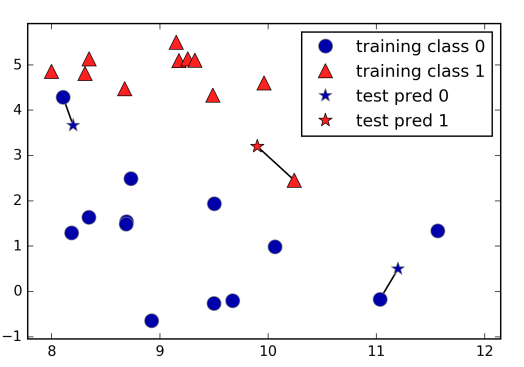

Modelo k = 3 (3 vecinos más cercanos):

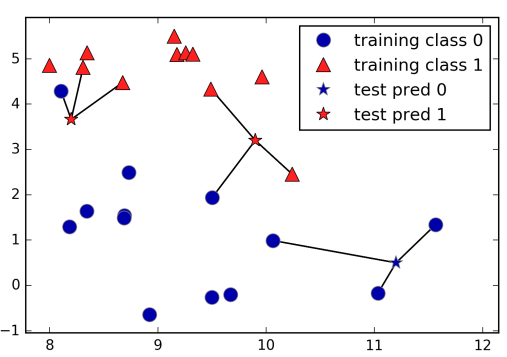

### Actividad Nro 2

La barrera hematoencefálica (BBB) es una estructura altamente selectiva que protege el cerebro al limitar el paso de sustancias y compuestos tóxicos desde el torrente sanguíneo hacia el cerebro. La capacidad de un compuesto para atravesar la BBB es crucial en el diseño de fármacos para el tratamiento de enfermedades del sistema nervioso central, ya que un bajo índice de permeabilidad puede impedir que el compuesto alcance su objetivo terapéutico en el cerebro.

El estudio de las propiedades TPSA (Área de Superficie Polar Total) y LogP (Logaritmo del Coeficiente de Partición Octanol-Agua) ha demostrado ser crucial en la evaluación y predicción de las características y comportamientos de los compuestos químicos.

El TPSA es una medida que estima la superficie total de un compuesto que es polar y, por lo tanto, capaz de formar enlaces por puentes de hidrógeno con su entorno.

Esta propiedad es importante ya que influye en:

* la solubilidad de los compuestos
* la biodisponibilidad de los compuestos
* la capacidad del compuesto para interactuar con proteínas y otros receptores biológicos
* Un mayor TPSA puede indicar una mayor probabilidad de interacciones con la superficie de una célula, lo que puede afectar la absorción y distribución de un compuesto en el organismo.

El LogP es un parámetro que describe la hidrofobicidad de una molécula, es decir, su afinidad por las sustancias lipídicas o grasas en comparación con el agua.

Este coeficiente de partición octanol-agua se utiliza ampliamente para evaluar la capacidad de una molécula para atravesar las membranas biológicas, incluida la barrera hematoencefálica.

Utilizaremos estos dos parámetros para entrenar un clasificador de K-NNs para clasificar compuestos que atraviesan la BBB.

In [ ]:
# @title Descargando bases de datos y leyendo con pandas

import pandas as pd

try:
    bbb = pd.read_csv("https://raw.githubusercontent.com/sebastianjinich/material_tps_bioinfo/main/BBB-dataset.csv")
    print("Se cargó la base de datos de BBB en la variable bbb")
except:
    print("No se descargó la db de BBB")

print(bbb.head(5))

Se cargó la base de datos de BBB en la variable bbb
                                   SMILES BBB
0                     CCCCNC(=S)Nc1ccccc1   +
1             CCCCCCN1CCN(CC1)c1ccc(I)cc1   +
2  OCc1nnc2CN=C(c3ccccc3)c3cc(Cl)ccc3-n12   -
3             CC(C)CN1CCN(CC1)c1ccc(I)cc1   +
4                                  CCCCCO   +


In [ ]:
# @title Complete los dos conjuntos de datos con los parámetros necesarios

logPs_bbb = []
tpsas_bbb = []

for index, row in bbb.iterrows():
    smile = row['SMILES']
    molecula = Chem.MolFromSmiles(smile)
    logPs_bbb.append(Descriptors.MolLogP(molecula))
    tpsas_bbb.append(Descriptors.TPSA(molecula,includeSandP = True))

bbb['logP'] = logPs_bbb
bbb['TPSA'] = tpsas_bbb

print(bbb.head(5))

                                   SMILES BBB    logP   TPSA
0                     CCCCNC(=S)Nc1ccccc1   +  2.7731  56.15
1             CCCCCCN1CCN(CC1)c1ccc(I)cc1   +  3.9935   6.48
2  OCc1nnc2CN=C(c3ccccc3)c3cc(Cl)ccc3-n12   -  2.7640  63.30
3             CC(C)CN1CCN(CC1)c1ccc(I)cc1   +  3.0692   6.48
4                                  CCCCCO   +  1.1689  20.23


(-8.0, 10.0)

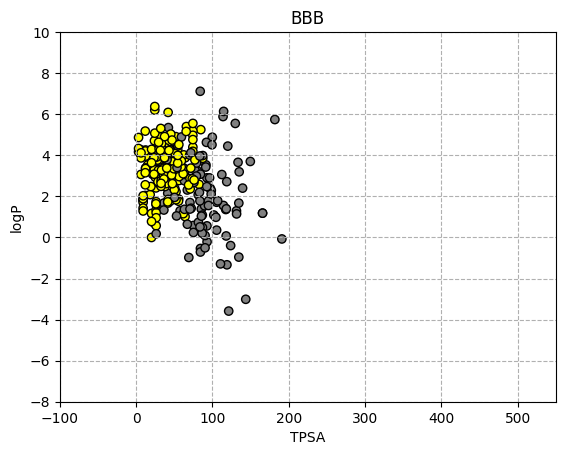

In [ ]:
# @title Visualizando los datos en scatter plot
xmin = -100
xmax = 550
ymin = -8
ymax = 10
palette = {"+":"yellow","-":"gray"}

plt.scatter(bbb['TPSA'],bbb['logP'],c=bbb['BBB'].map(palette),edgecolors="black")
plt.xlabel('TPSA')
plt.ylabel('logP')
plt.title('BBB')
plt.grid(True,linestyle="--")
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

In [ ]:
#@ title Unificamos los datos.
replacement = {"+":1,"-":0}
bbb.loc[:,"BBB"] = bbb.loc[:,"BBB"].map(replacement)
print(bbb.head(5))

                                   SMILES BBB    logP   TPSA
0                     CCCCNC(=S)Nc1ccccc1   1  2.7731  56.15
1             CCCCCCN1CCN(CC1)c1ccc(I)cc1   1  3.9935   6.48
2  OCc1nnc2CN=C(c3ccccc3)c3cc(Cl)ccc3-n12   0  2.7640  63.30
3             CC(C)CN1CCN(CC1)c1ccc(I)cc1   1  3.0692   6.48
4                                  CCCCCO   1  1.1689  20.23


In [ ]:
!pip install mglearn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import mglearn

X = bbb.loc[:,['TPSA','logP']]
y = bbb.loc[:,'BBB'].astype(int).to_numpy()

# dividir en training y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

# Estandarizar los datos
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# definir el algoritmo
clf = KNeighborsClassifier(n_neighbors=3)
# entrenar el algoritmo
clf.fit(X_train_scaled, y_train)
# Aplico el model al set de evaluación
print("Test set predictions: {}".format(clf.predict(X_test_scaled)))
# Evaluo el modelo
print("Test set accuracy: {:.2f}".format(clf.score(X_test_scaled, y_test)))


Test set predictions: [1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0
 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1]
Test set accuracy: 0.88


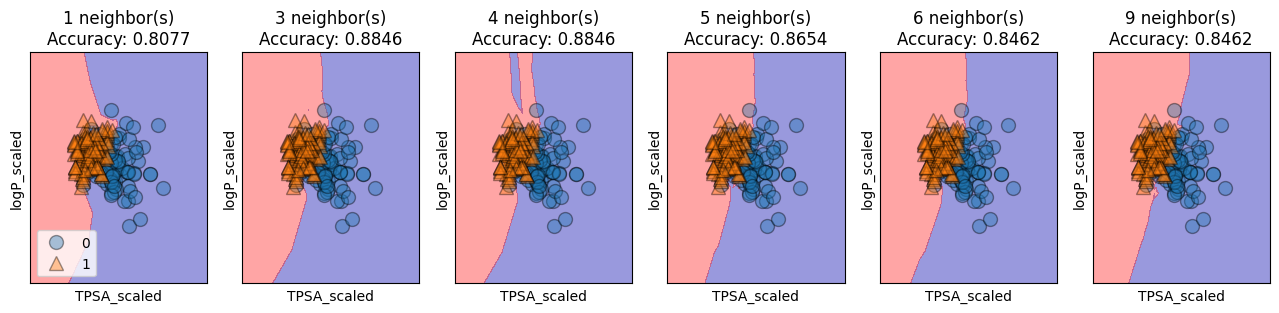

In [ ]:
# @title Ahora hacemos varios modelos con distintos K

from sklearn.metrics import accuracy_score

X_np = X.to_numpy()
# #obtener las tres figuras para k = 1, 3, 4, 5, 6 y 9
fig, axes = plt.subplots(1, 6, figsize=(16, 3))
for n_neighbors, ax in zip([1, 3, 4, 5, 6, 9], axes):
  # the fit method returns the object self, so we can instantiate
  # and fit in one line
  # Fit the classifier using the scaled data
  clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train_scaled, y_train)
  y_pred = clf.predict(X_test_scaled)
  score = accuracy_score(y_test, y_pred)

  # Plot the decision boundaries
  mglearn.plots.plot_2d_separator(clf, X_train_scaled, fill=True, eps=0.5, ax=ax, alpha=.4)
  mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], y_train, ax=ax,alpha=.4)
  ax.set_title(f'{n_neighbors} neighbor(s)\nAccuracy: {round(score,4)}')
  ax.set_xlabel("TPSA_scaled")
  ax.set_ylabel("logP_scaled")
axes[0].legend(loc=3)

### Métricas para métodos de Clasificación

Existen muchas métricas las más comunes son:

* Accuracy
* Precision
* Recall
* Área bajo la curva (Area under curve - AUC)
* Matriz de confusión

En un método de clasificación podemos evaluar como el clasificador clasifica nuestros datos. Por lo tanto, luego de realizar la predicción en el **set de evaluación o validación** vamos a tener:

* **True Positives (TP):** El clasificador lo clasifica correctamente (es positivo y lo clasifica positivo)

* **True Negatives (TN):** El clasificador lo clasifica correctamente (es negativo y lo clasifica negativo)

* **False Positives (FP):** El clasificador lo clasifica incorrectamente (es negativo y lo clasifica positivo)

* **False Negatives (FN):** El clasificador lo clasifica incorrectamente (es positivo y lo clasifica negativo)


#### **Accuracy**

Es la proporción de cosas predichas correctamente.

$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$


#### **Recall**

Es la proporción de positivos predichos correctamente.

Es decir, de todos los positivos ($TP+FN$) cuales son predichos positivos ($TP$).

$$
Recall = \frac{TP}{TP+FN}
$$


#### **Specificity**

Es la proporción de negativos predichos correctamente.

Es decir, de todos los negativos ($TN+FP$) cuales son predichos negativos ($TN$).

$$
Specificity = \frac{TN}{TN+FN}
$$

### **Matthews Correlation Coefficient (o phi coefficient)**

Es una medida de la calidad de la clasificación (binaria o múltiple).

Es una medida balanceada que se puede usar aún cuando las distintas clases no tienen tamaños similares.

MCC varía entre -1 y +1.
* +1: Predicción perfecta
* 0: Predicción azarosa
* -1: Predicción invertida

$$
MCC = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}.
$$




In [ ]:
# @title Métricas para nuestro modelo de K-NN
from sklearn.metrics import recall_score, precision_score, matthews_corrcoef, confusion_matrix

n_neighbors = 3
clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)

mcc = matthews_corrcoef(y_test,y_pred)

print(f"Accuracy: {round(accuracy,4)}")
print(f"Recall: {round(recall,4)}")
print(f"Precision: {round(precision,4)}")
print(f'Specificity: {round(specificity,4)}')
print(f'MCC: {round(mcc,4)}')


Accuracy: 0.8846
Recall: 0.9143
Precision: 0.9143
Specificity: 0.8235
MCC: 0.7378


## Support Vector Machines

SVMs son una extensión de los modelos lineales de clasificación que permiten modelos más complejos que aquellos que no están definidos simplemente por hiperplanos en el espacio dado.

En los SVMs, se construye un hiperplano o conjunto de hiperplanos en un espacio de dimensionalidad muy alta.

Este hiperplano separa a los puntos de una clase de la otra, que eventualmente han podido ser previamente proyectados a un espacio de dimensionalidad superior.

**Support Vectors** son los puntos de los datos, que son los más cercanos al hiperplano. Estos puntos definirán mejor la linea de separación por el cálculo de márgenes y son los más relevantes para la construcción del clasificador.

**Hiperplano** es el plano de decisión que separa entre un conjunto de objetos que pertenecen a distintas clases.

**Margen** es un *gap* entre dos líneas en los puntos de una clase más cercanos.

Se calcula como la distancia perpendicular a la linea de los Support vector o puntos más cercanos. Si el margen es grande entre las clases, entonces es un buen margen. Un margen pequeño, es un mal margen.

Algunos problemas **no** pueden resolverse usando un hiperplano lineal.

En esos casos, SVM usa un *kernel* para transformar el espacio de entrada en un espacio con más dimensiones. Por ejemplo, crea una variable Z que es la suma de los cuadrados de x e y: $z=x^2+y^2$.
Esto permite la segregación de los datos y la utilización de planos lineales.

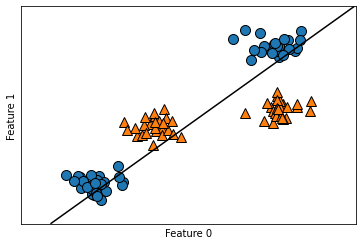

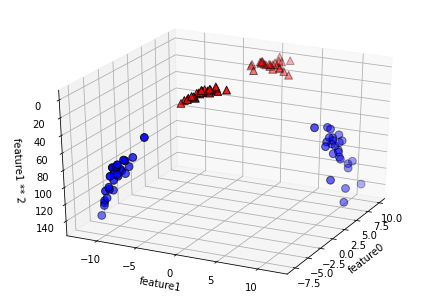

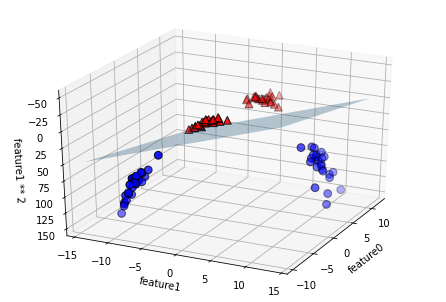

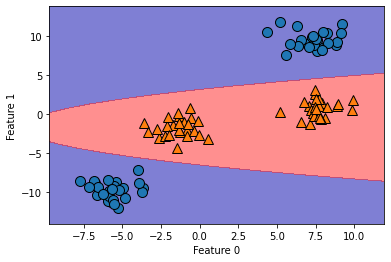

#### Kernel

Un kernel transforma el espacio de datos de entrada en la forma requerida.

En el caso de SVM se usa una ténica llamada *kernel trick*. El kernel toma, un espacio de entrada de pocas dimensiones y lo transforma en un espacio dimensaional mayor.

Convierte problemas no separables en separables por el agregado de más dimensiones. Permitiendo construir un clasificador más preciso.

* **Kernel Lineal:**
$$
K(x_i,x_j) = \sum_{i,j=1 , i \neq j} (x_i \cdot x_j)
$$

* **Kernel polinomial:**

$$
K(x_i,x_j) = \left(\sum_{i,j=1 , i \neq j} \gamma \cdot x_i \cdot x_j + r\right)^d
$$

donde $d$ es el grado de la polinomial, y es definido por el usuario, $\gamma$ controla la influencia de cada muestra individual en la decisión de los límites y $r$ es el bias.
  
* **Radial basis function Kernel**

$$
K(x_i,x_j) = e^{-\gamma \cdot \sum_{i,j=1 , i \neq j}(x_i – x_j)^2}
$$

donde $\gamma$ es un parámetro definido por el usuario y controla la influencia de cada muestra individual en la decisión de los límites.

Este parámetro varía entre **0** y **1**. Un mayor valor de gamma hará unn ajuste perfecto del set de entrenamiento, causando overfitting. Gamma=0.1 se considera un buen valor por defecto.

In [ ]:
# @title Función para plotear cosas de SVM
from sklearn.inspection import DecisionBoundaryDisplay


def plot_training_data_with_decision_boundary(clf,X,kernel,y,ax=None, long_title=True, support_vectors=True):
    # Train the SVC
    #clf = svm.SVC(kernel=kernel, gamma=2).fit(X, y)

    # Settings for plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 3))
    x_min, x_max, y_min, y_max = -min(X[:,0])-0.5, max(X[:,0])+0.5, -min(y)-0.5, max(y)+0.5
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    if support_vectors:
        # Plot bigger circles around samples that serve as support vectors
        ax.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=150,
            facecolors="none",
            edgecolors="k",
        )

    # Plot samples by color and add legend
    scatter_plot = ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
    ax.legend(*scatter_plot.legend_elements(), loc="upper right", title="Classes")
    if long_title:
        ax.set_title(f" Decision boundaries of {kernel} kernel in SVC")
    else:
        ax.set_title(kernel)

    if ax is None:
        plt.show()

In [ ]:
#@ title Aplicando SVM a nuestros datos

#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel
#clf = svm.SVC(kernel='poly',degree=2) # Poly Kernel
# clf = svm.SVC(kernel='rbf',gamma=0.2) # RBF Kernel gamma default: 'scale', gamma=1/(n_features*X.var())

#Train the model using the training sets
clf.fit(X_train_scaled, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_scaled)
y_pred_train = clf.predict(X_train_scaled)

# Evaluamos el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Accuracy on training data:", accuracy_score(y_train, y_pred_train))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", recall_score(y_test, y_pred))


Accuracy: 0.8846153846153846
Accuracy on training data: 0.875
Precision: 0.9142857142857143
Recall: 0.9142857142857143


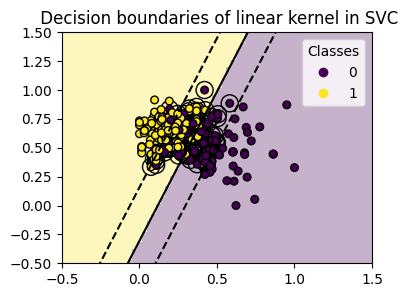

In [ ]:
plot_training_data_with_decision_boundary(clf=clf,X=X_train_scaled,kernel='linear',y=y_train)

## Árboles de decisión (Decision Trees)

Son modelos de clasificación ampliamente usados. Principalmente, aprenden una jerarquía/serie de preguntas 'if/else', que llevan a la decisión.

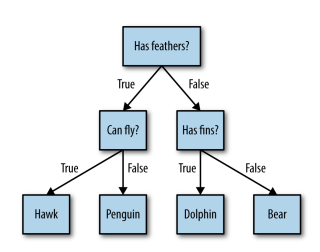

Es decir, que entrenar un **árbol de decisión** significa aprender la secuencia de preguntas 'if/else' para llegar a la respuesta lo más rápido posible.

Estas preguntas se llaman **tests** (en este caso, *test* no se refiere al set de evaluación). Estos *tests* no tienen por qué ser en forma de pregunta *binaria* (sí o no), sino que pueden representar variables continuas.

### Complejidad del árbol de decisión:

Para evitar **overfitting**, hay dos estrategias principales:

* Parar de forma temprana la creación del árbol, lo que se conoce como **pre-pruning**,
* o bien, construir el árbol completo para luego eliminar o unir nodos que contienen apenas información, lo que se conoce como **post-pruning o pruning**.

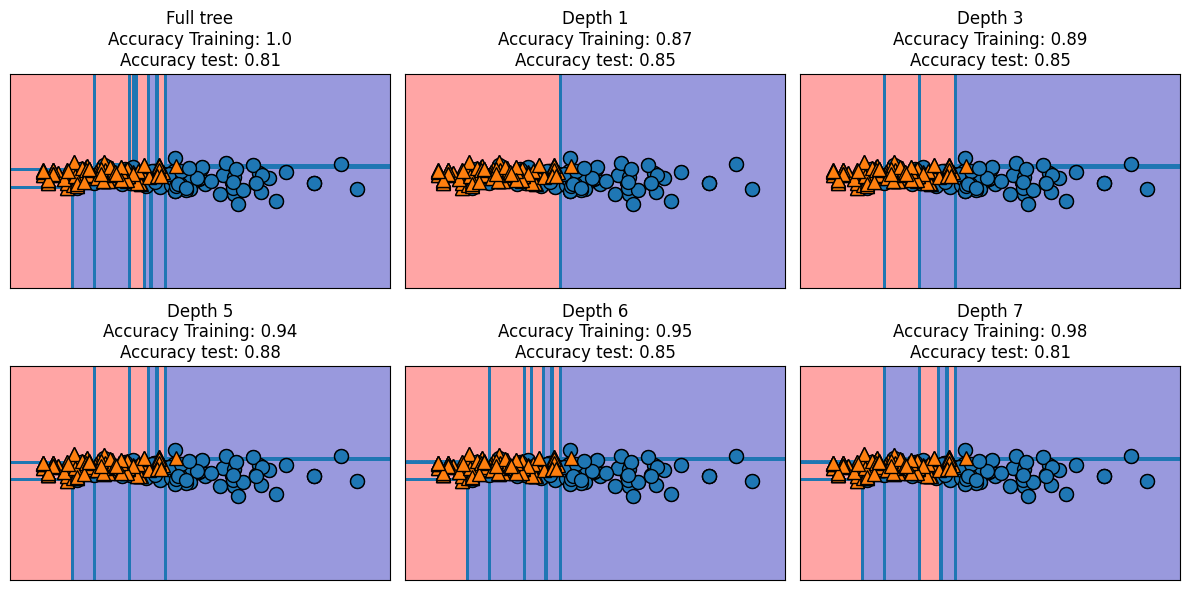

In [ ]:
#from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

# definir el algoritmo
tree = DecisionTreeClassifier(random_state=0)

# entrenar el algoritmo
tree.fit(X_train.values, y_train)

y_pred_train = tree.predict(X_train.values)
y_pred_test = tree.predict(X_test.values)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

ax1 = axes[0,0]
mglearn.plots.plot_tree_partition(X_train.values, y_train, tree, ax=ax1)
# mglearn.plots.plot_2d_separator(tree, X_train.values, fill=True, ax=ax1, alpha=.4)
mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, ax=ax1)
ax1.set_title(f"Full tree\nAccuracy Training: {round(accuracy_score(y_pred_train, y_train),2)}\nAccuracy test: {round(accuracy_score(y_pred_test, y_test),2)}")

depth = [1,3,5,6,7]

for i in range(0,len(depth)):
# repetir cambiando la complejidad del algoritmo para reducir overfitting
  tree = DecisionTreeClassifier(max_depth=depth[i], random_state=0)
  tree.fit(X_train.values, y_train)
  y_pred_train = tree.predict(X_train.values)
  y_pred_test = tree.predict(X_test.values)

  if i > 1:
    pos = (i+1)%3
    ax1 = axes[1,pos]
  else:
    ax1 = axes[0,i+1]
  mglearn.plots.plot_tree_partition(X_train.values, y_train, tree, ax=ax1)
  # mglearn.plots.plot_2d_separator(tree, X_train.values, fill=True, ax=ax1, alpha=.4)
  ax1.set_title(f"Depth {depth[i]}\nAccuracy Training: {round(accuracy_score(y_pred_train, y_train),2)}\nAccuracy test: {round(accuracy_score(y_pred_test, y_test),2)}")
  mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, ax=ax1)

fig.tight_layout()


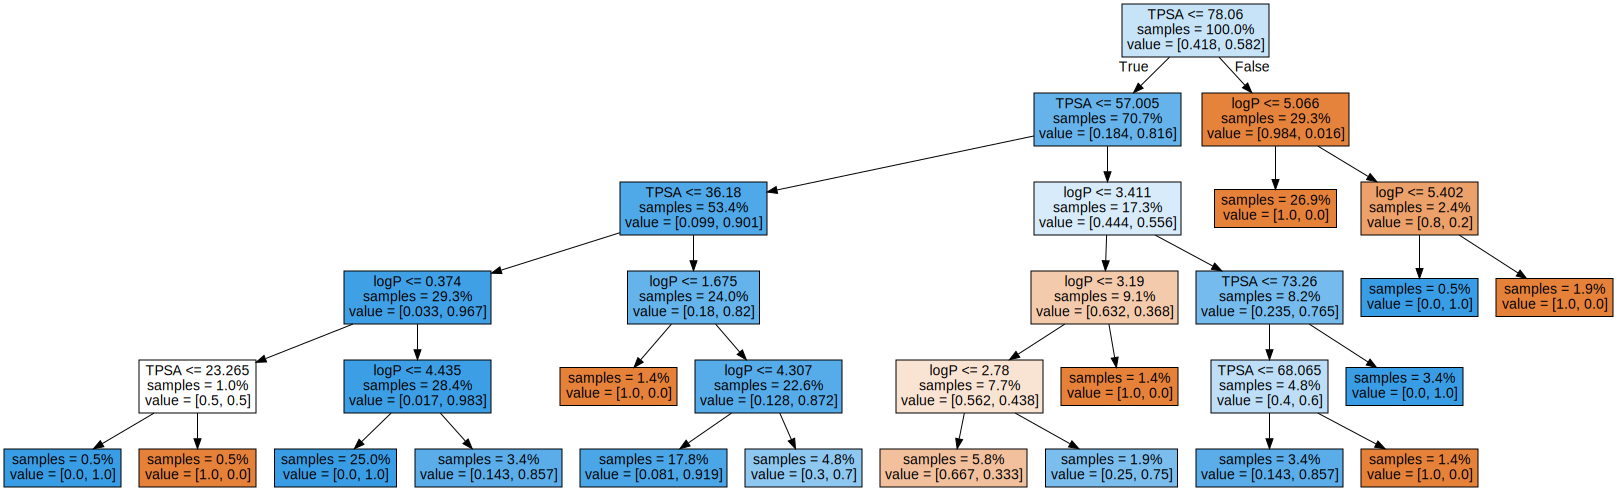

In [ ]:
# @title Graficando el árbol de decisión

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

deep = 5
tree = DecisionTreeClassifier(max_depth=deep, random_state=0)
tree.fit(X_train.values, y_train)

dot_data = export_graphviz(tree,
                            feature_names=X_train.columns,
                            filled=True,
                            max_depth=deep,
                            impurity=False,
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)


## Random Forests

Los *ensemble models* son métodos que combinan múltiples predicciones de otros modelos.

Random forests son un tipo de *ensemble models*. Cada uno de los modelos más pequeños en este caso es un árbol de decisión.

Brevemente, se crean múltiples árboles de decisión usando un subconjunto azaroso de los datos y características.

Las predicciones se realizan calculando la predicción de cada árbol de decisión y luego tomando el resultado más popular (Para regresiones, se utiliza un promedio de la predicción).

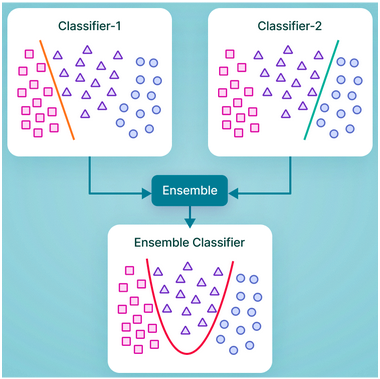

Por ejemplo, se realiza un *random forest* con $n$ árboles de decisión. En la siguiente figura se muestran los 5 primeros con su predicción (*Dog* o *Cat*). Los círculos verdes indican un camino hipotético que el árbol siguió para llegar a su decisión.

Cada árbol es expuesto a un número diferente de características y a una muestra diferente del conjunto de datos original y, por lo tanto, cada árbol puede ser diferente. Cada uno de los árboles hace una predicción.

En los primeros 5 árboles, 4 de 5 predicen que la muestra era un *Cat*. El *random forest* cuenta el número de predicciones de los árboles de decisión para *Cat* o *Dog* y elige la predicción más popular (la *más votada*).

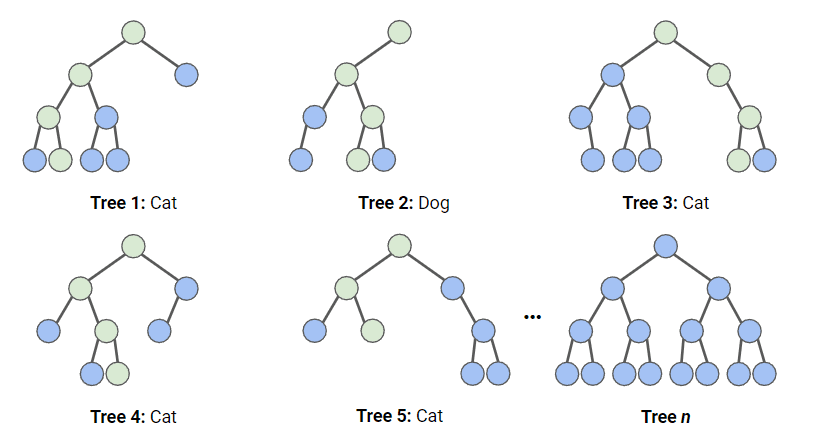

Accuracy: 0.8653846153846154


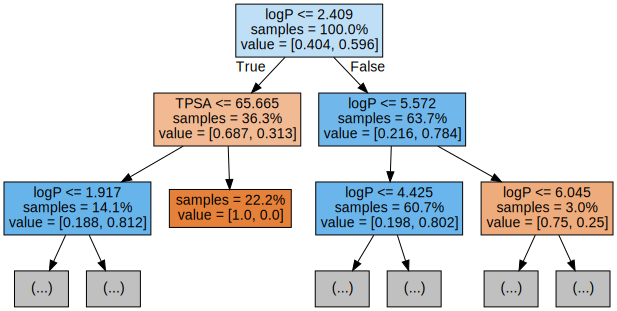

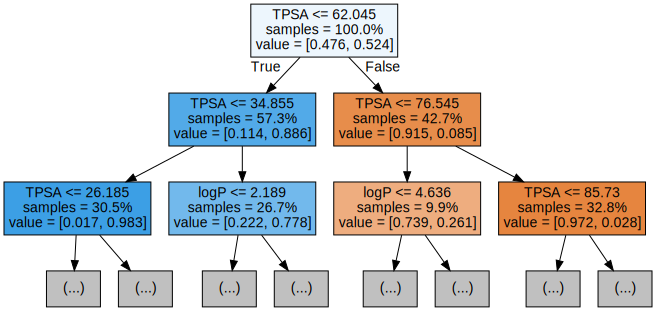

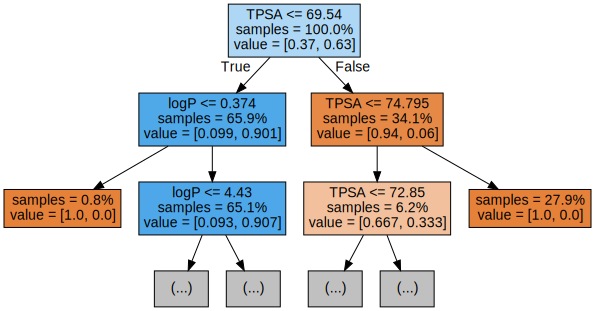

In [ ]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Training the model
rf = RandomForestClassifier(n_estimators=5,random_state=42)
rf.fit(X_train.values, y_train)

# Making the prediction
y_pred = rf.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


Cada imagen del árbol está limitada a sólo mostrar los primeros nodos. Los colores representan la clase mayoritaria de cada nodo (rojo indicando la propoción cercana a 0, y azul indicando una propoción cercana a 1).

En cada nodo se muestra:
* El nombre de la variable usada para la división
* El % de la muestra en cada división
* La proporción dividida entre clases en cada división.



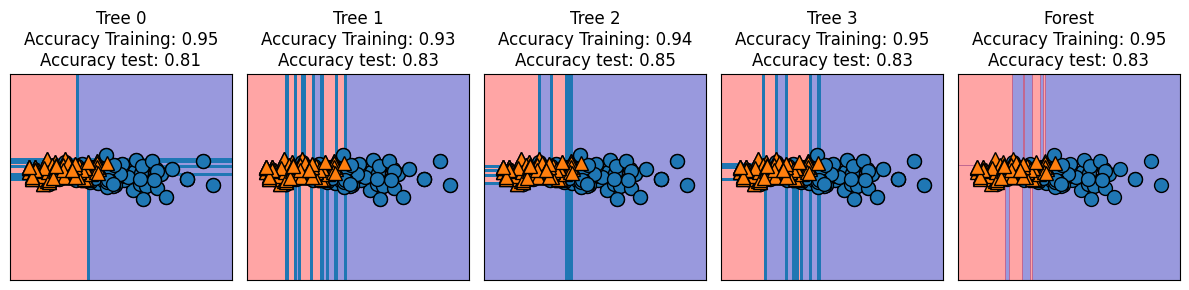

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))

for i in range(5):
  ax1 = axes[i]

  if i!=4:
    tree = rf.estimators_[i]
    y_pred_train = tree.predict(X_train.values)
    y_pred_test = tree.predict(X_test.values)
    mglearn.plots.plot_tree_partition(X_train.values, y_train, tree, ax=ax1)
    mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, ax=ax1)
    ax1.set_title(f"Tree {i}\nAccuracy Training: {round(accuracy_score(y_pred_train, y_train),2)}\nAccuracy test: {round(accuracy_score(y_pred_test, y_test),2)}")
  else:
    # mglearn.plots.plot_tree_partition(X_train.values, y_train, tree, ax=ax1)
    mglearn.plots.plot_2d_separator(rf, X_train.values, fill=True, ax=ax1, alpha=.4)
    mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, ax=ax1)
    ax1.set_title(f"Forest\nAccuracy Training: {round(accuracy_score(y_pred_train, y_train),2)}\nAccuracy test: {round(accuracy_score(y_pred_test, y_test),2)}")

fig.tight_layout()


### Ejercicio Integratorio

Este es un pequeño ejercicio práctico a partir de un conjunto de datos de compuestos donde se estudio su capacidad inhibitoria en el género Enterovirus (Bacterias).

El objetivo es entrenar un modelo sencillo de machine learning a partir de descriptores moleculares para clasificar compuestos.

Estos compuestos se han obtenido en ChEMBL, filtrando por:

- Actividad: IC50
- Organismo: Enterovirus
- Formato: organism-based format

Obteniendo un conjunto de 276 actividades, concentraciones medidas en nM.
Algunos compuestos estaban repetidos, por lo que en este caso se ha obtenido un valor medio de IC50 (para este caso), obteniendo así un total de valores para 98 compuestos.

**Primer Paso:** Clasificar estos datos en dos grupos en función de su IC50. Estos datos están en nM. El umbral propuesto es de 1000nM, ya que este umbral da dos grupos de tamaño similar, pero el valor a elegir depende de cada caso de estudio.

También es importante confirmar que todas las SMILES vienen en un formato válido, y eliminar aquellas que no lo sean.

Recuerden que si empezaran de cero este ejercicio tendrían que:

1. Instalar las librerías necesarias
2. Importar las librerías necesarias

In [ ]:
# @title Descarga los datos

# Data available in GitHub repository
url = 'https://raw.githubusercontent.com/mvillacampafdez/Chemoinf_july23/main/enterovirus_unique.csv'
# obtener los datos del url
enterovirus = pd.read_csv(url)

In [ ]:
# @title Instalación de las librerías necesarias

# Escribe aquí tu código

In [ ]:
# @title Importación de las librerías necesarias

# Escribe aquí tu código

In [ ]:
# @title Evaluación de que los SMILES son válidos

SMILES = [] # Creo una lista vacía donde voy a guardar los smiles que funcionan bien
IC50 = [] # Creo una lista vacía donde guardo las IC50 de los smiles que funcionan bien
for i in range(len(enterovirus['SMILES'])): # Itero por la columna smiles
  try:
    # Intento canonicalizar el string del smiles, es decir, convertirlo a
    # una representación estándar única. Si el smiles es válido, lo guardo, en
    # la lista SMILES, y el IC50 en la lista smiles.
    cs = Chem.CanonSmiles(enterovirus['SMILES'][i])
    SMILES.append(cs)
    IC50.append(enterovirus['IC50'][i])
  except:
    # Si el smiles es inválido, lo imprimo
    print('Invalid SMILES:', enterovirus['SMILES'][i],i)

print('Loop Ended')

In [ ]:
# @title Clasificación de la actividad

# Completa el código con lo que falta

# Lista vacía para guardar la clasificación de Active (IC50 < 1000) e Inactive
Activity = []

for i in IC50:
  # Completar aquí !


Bien! Ya tenemos una lista clasficando en base al IC50 si los compuestos son activos o inactivos.

Si hiciste las cosas bien, tendrías que obtener 56 compuestos activos y 42 compuestos inactivos.

Una forma de contar eso es usando el siguiente código:

`Activity.count('Active')`

**Segundo Paso:** Ahora, tenemos que obtener una serie de descriptores moleculares, para aquellos que nunca los obtuvimos o no obtuvimos algo similar al lado del nombre se indica el comando para hacerlo:

* Número de Átomos totales
* Número de Carbonos
* Número de Nitrógenos
* Número de Oxígenos
* Peso Molecular
* Número de Anillos Aromáticos: `Descriptors.RingCount(mol)`
* TPSA
* Density de Morgan: `Descriptors.FpDensityMorgan1(mol)`
* Número de Rotable Bonds

In [ ]:
# @title Obtención de descriptores. Completar el código.

# Escribe aquí tu código! A modo de ejemplo mostramos parcialmente como se haría
# para obtener # la lista de moléculas y el número de átomos totales

moleculas = [ COMPLETAR for smiles in SMILES ]
numero_atomos = [ COMPLETAR for mol in moleculas]


In [ ]:
# @title Formateo como data.frame. Modifica el código según sea necesario.

# Una forma de obtener un data.frame cuando se tienen muchas listas es la siguiente
# Todo lo que está adentro del zip son los nombres de las listas que armaste en el paso anterior,
# numero_atomos = Numero de atomos totales
# C = Número de Carbonos
# O = Número de Oxígenos etc etc etc

descriptors_df = pd.DataFrame(list(zip(numero_atomos, C, O, N, MolWeight, Rings, TPSA, FpDM1, RotBonds)))
descriptors_df.columns = ['Numero_atomos', COMPLETAR]

descriptors_df

**Tercer Paso:** Ahora que tenemos el conjunto de datos es necesario entrenar y validar un modelo para que prediga compuestos posiblemente activos e inactivos. Para esto:

1. Hay que dividir el set de datos en training, testing y validación.
2. Evaluar si es necesario estandarizar los datos.
3. Entrenar uno o más modelos
4. Validar cada modelo
5. Evaluar el modelo

El algoritmo de machine learning elegido es K-NN

In [ ]:
# @title División del set de datos en: Set de entrenamiento, validación y testing.

# Escribe tu código aquí, recuerda elegir un random_state para que tu división sea
# siempre la misma a medida que pruebes cosas.


In [ ]:
# @title Estandarización de los datos

# Escribe tu código aquí !

In [ ]:
# @title Creación del modelo

# Importar la librería necesaria


# Inicializar el algoritmo


# Entrenar el algoritmo con nuestros datos


# Predecir en el set de validación


# Probar más parámetros y predecir en el set de validación (es decir, crear otros modelos)




In [ ]:
# @title Validación de los distintos modelos

# Calculas las métricas de validación necesarias

In [ ]:
# @title Evaluar el modelo

# Predecir con el modelo elegido sobre el set de evaluación.